In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# import tensor flow library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
tf.random.set_seed(42)

# import modules to graph ANN
import pydot
import pydotplus
import graphviz
import math
import scipy.stats



TFP Version 0.8.0
TF  Version 2.1.0


## Import Data

In [2]:
# Read data from files 
# get data from csv file
DataLow = pd.read_csv('Dataset.csv')
# split traing and valiating data
X_train = DataLow[['sigmaMeanNormalized' ,'nNormalized']][:28]
X_valid = DataLow[['sigmaMeanNormalized' ,'nNormalized']][26:]
Y_train = DataLow[['Target']][:28]
Y_valid = DataLow[['Target']][26:]
# get P50% & P5% Stussi data
# # get P50% 
Data = pd.read_csv('StussP50.csv')
X_train_P50 = Data['nNormalized'][0:1200]
X_valid_P50 = Data['nNormalized'][1200:]
Y_train_P50 = Data[['Target']][0:1200]
Y_valid_P50 = Data[['Target']][1200:]

# get experimental data
ExpData= pd.read_csv('Experimental Data.csv')
# split traing and valiating data
ExpX_train = ExpData[['sigmaMeanNormalized' ,'nNormalized']][:22]
ExpX_valid = ExpData[['sigmaMeanNormalized' ,'nNormalized']][22:]
ExpY_train = ExpData[['Target']][:22]
ExpY_valid = ExpData[['Target']][22:]

# Create PNN 

In [5]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 
# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.02 + tf.math.softplus(0.005 * params[:,1:2]) )# both parameters are learnable

# Create the PNN
inputs = Input(shape=(2,))
hidden0 = Dense(200,activation=tf.keras.layers.LeakyReLU(alpha=0.3),kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden0) 
hidden1 = Dense(300,activation=tf.keras.layers.LeakyReLU(alpha=0.3),kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(200,activation=tf.keras.layers.LeakyReLU(alpha=0.3),kernel_regularizer=keras.regularizers.l2(0.001))(hidden1)
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(100,activation=tf.keras.layers.LeakyReLU(alpha=0.3),kernel_regularizer=keras.regularizers.l2(0.001))(hidden2)
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(my_dist)(params) 
# Create the model and compile it
modelPnnFatigue = Model(inputs=inputs, outputs=dist) 
modelPnnFatigue.compile(Adam(learning_rate=0.001), loss=NLL) 


## Model Summary

In [6]:
# Print model summary
modelPnnFatigue.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 300)          900         input_2[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 200)          60200       dense_8[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 200)          600         input_2[0][0]                    
____________________________________________________________________________________________

## Model Flow Chart

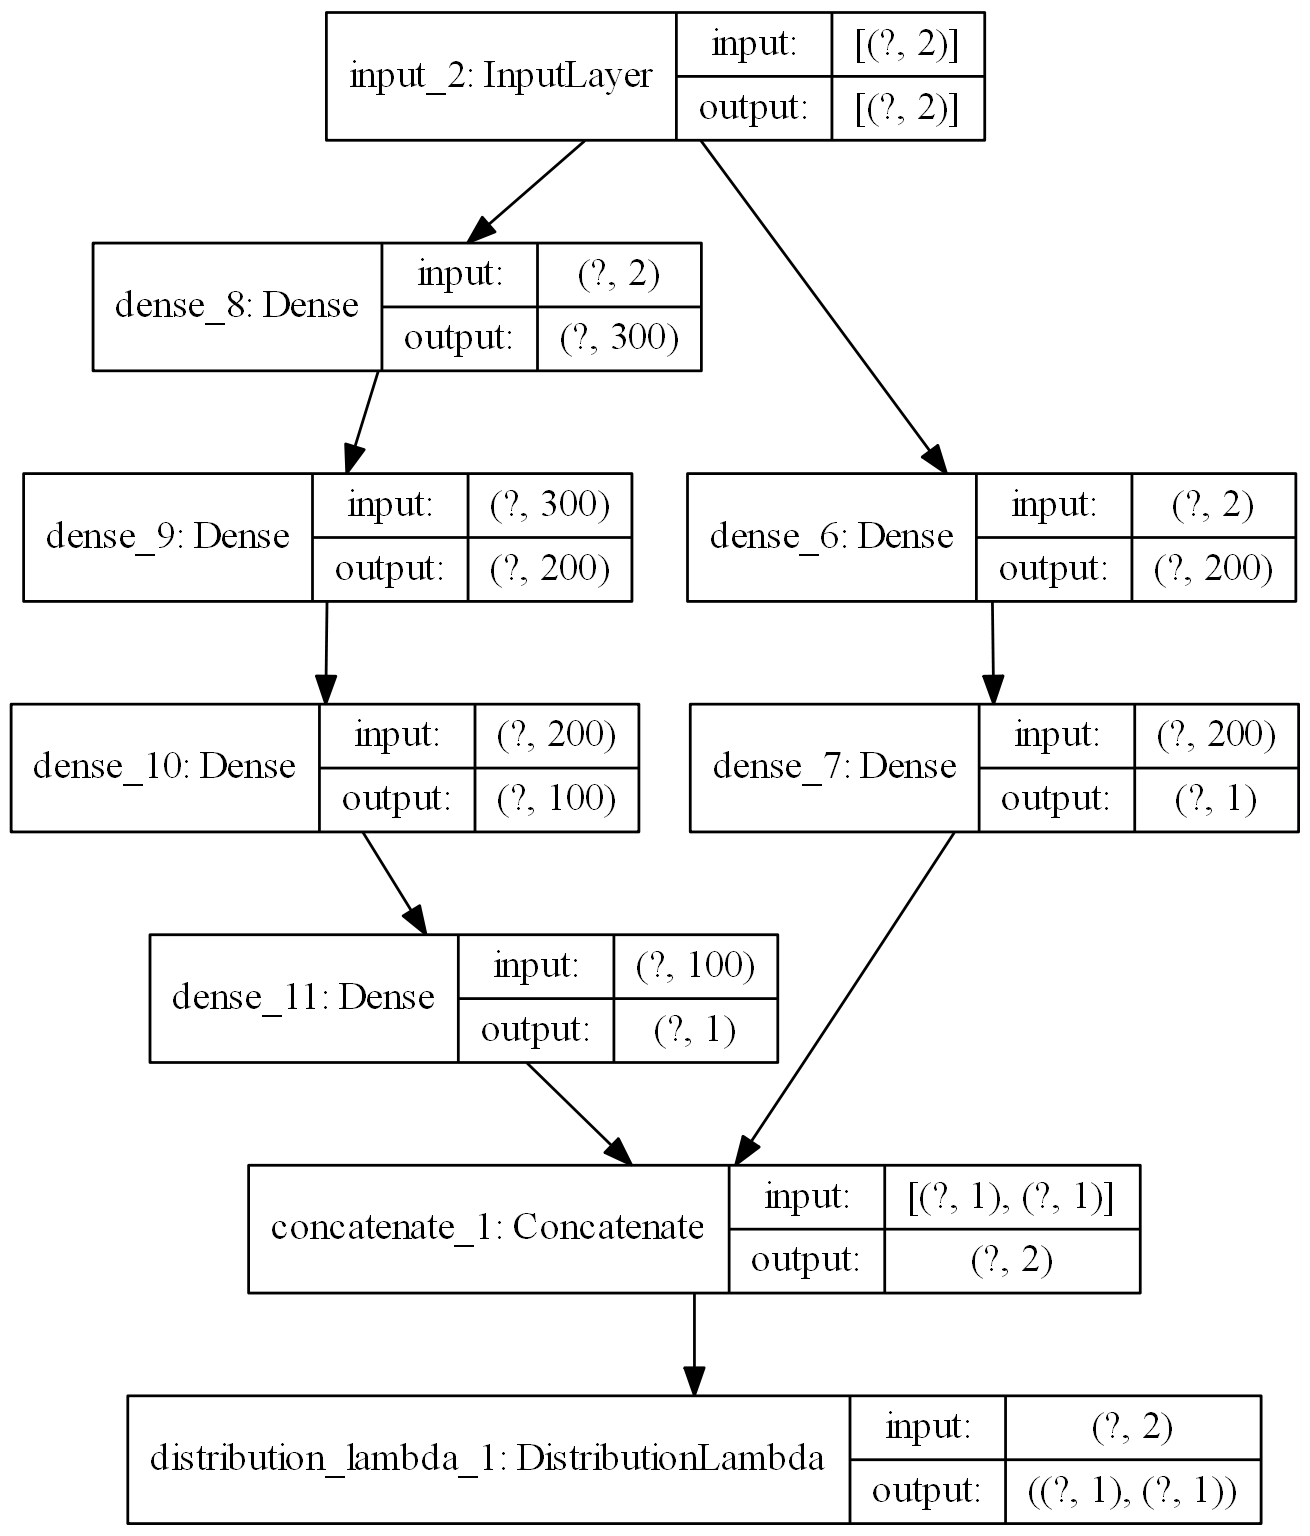

In [7]:
# Print network flow chart
keras.utils.plot_model(modelPnnFatigue, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=200
)

## Model Training 

In [8]:
# Train the model for number of epochs
history = modelPnnFatigue.fit(X_train, Y_train, epochs=40000, verbose=0, validation_data=(X_valid,Y_valid), shuffle= True)
modelPnnFatigue = Model(inputs=inputs, outputs=dist.mean())

##  Loss Evaluation

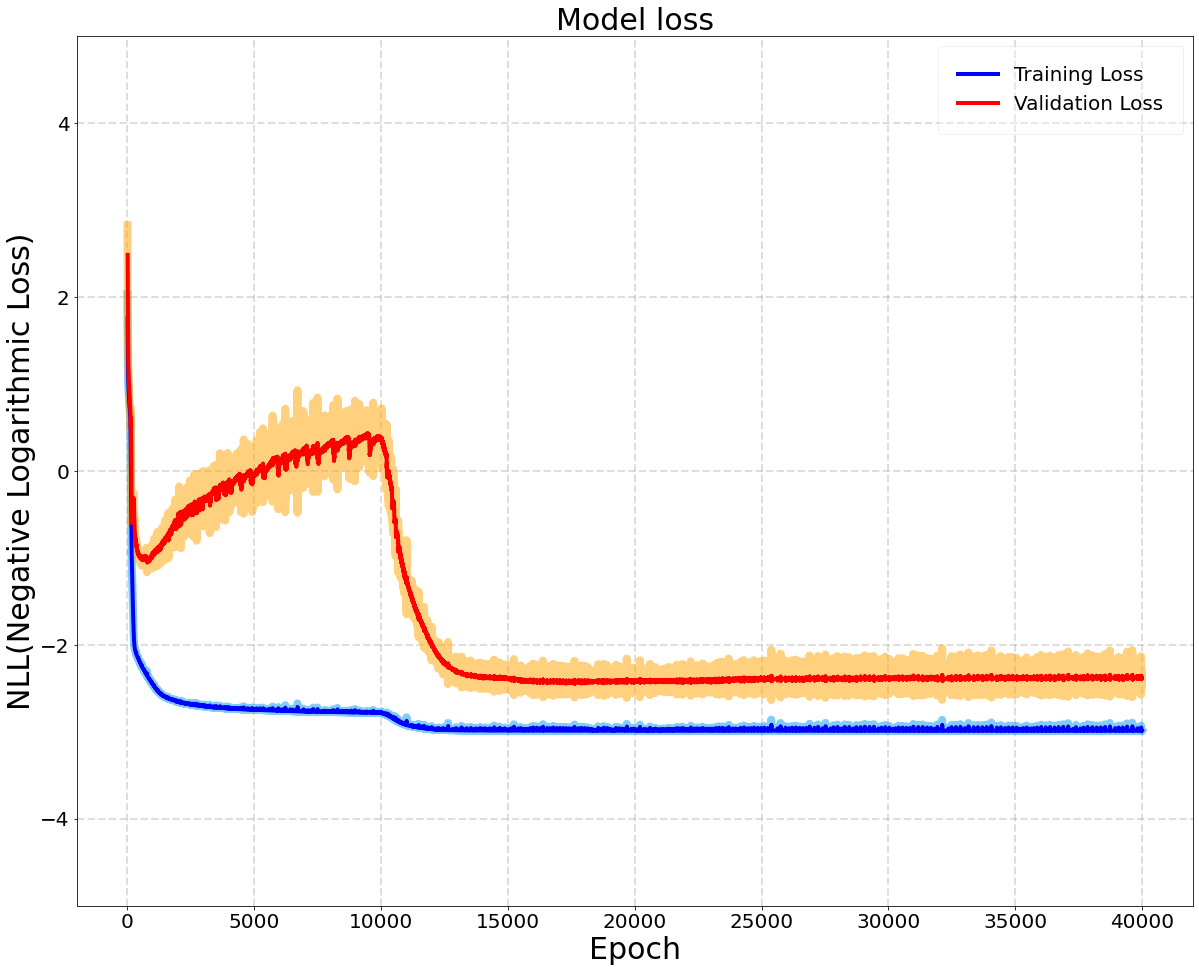

In [13]:
# Evalute netwroks training performance
df = pd.DataFrame(history.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()

plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')

plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.gca().set_ylim(-5,5)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

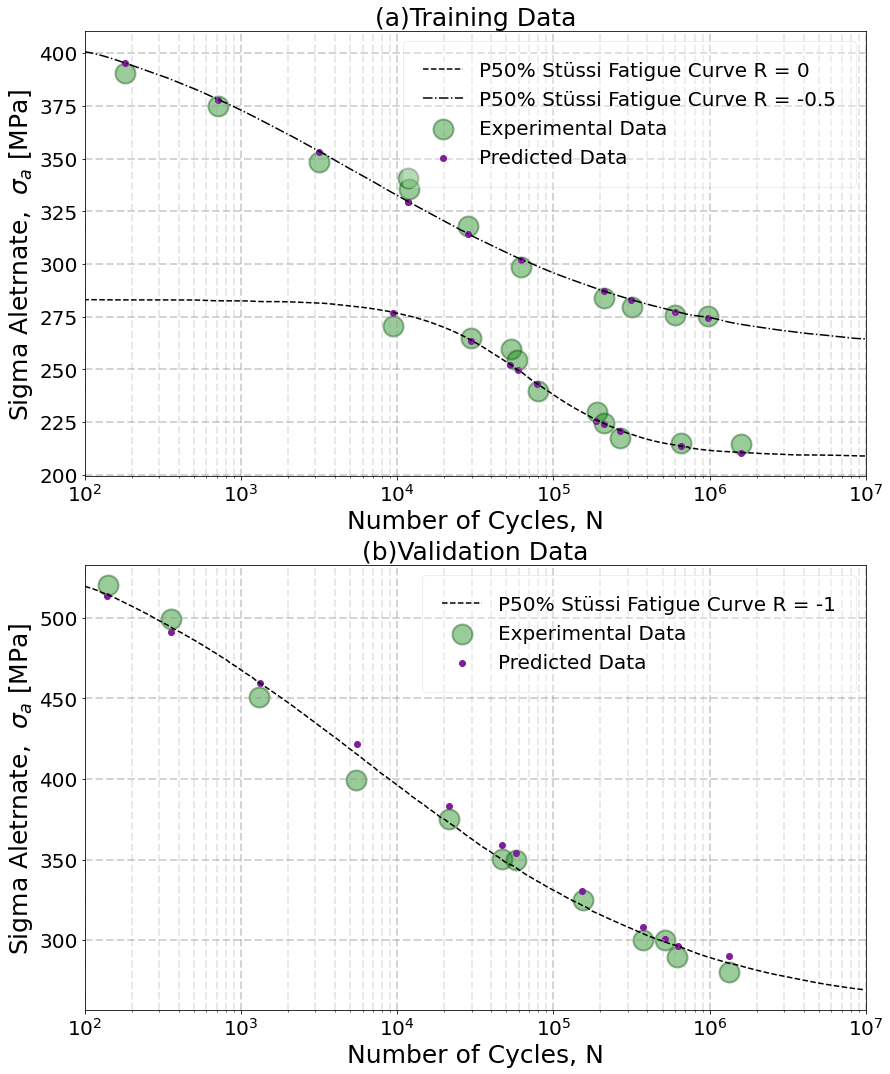

In [10]:
# Create figure
plt.figure(figsize=(14,18))
# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnFatigue.predict(X_train)
plt.scatter(np.power(10,[ExpX_train["nNormalized"][1:]*7]),ExpY_train[1:]*568/2,color="#008000",
            alpha = 0.4,s=400,linewidth=2, edgecolors="#054907",label = 'Experimental Data')
plt.scatter(np.power(10,[X_train["nNormalized"][5:-2]*7]),preds[5:-2]*568/2,color="#7E1E9C",
            label = 'Predicted Data') 
plt.plot( np.power(10,np.array ( X_train_P50[:600]).reshape([-1,1]) * 7), Y_train_P50[:600]*568/2,color="black",
         linestyle='--',label = 'P50% Stüssi Fatigue Curve R = 0')
plt.plot( np.power(10,np.array ( X_train_P50[600:]).reshape([-1,1]) * 7), Y_train_P50[600:]*568/2,color="black",
         linestyle='-.',label = 'P50% Stüssi Fatigue Curve R = -0.5')
plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.xlim([100,10000000])
plt.xscale('log')



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnFatigue.predict(X_valid)
plt.scatter(np.power(10,[ExpX_valid["nNormalized"]*7]),ExpY_valid*568/2,color="#008000", alpha = 0.4,
            s=400,linewidth=2, label = 'Experimental Data',edgecolors="#054907",)
plt.scatter(np.power(10,[X_valid["nNormalized"]*7]),preds*568/2,color="#7E1E9C",label = 'Predicted Data')
plt.plot( np.power(10,np.array (X_valid_P50).reshape([-1,1]) * 7),
         Y_valid_P50*568/2,color="black", linestyle='--',label = 'P50% Stüssi Fatigue Curve R = -1')
plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(b)Validation Data", size = 25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.xlim([100,10000000])
plt.xscale('log')
plt.grid(True)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()





# Calculate correaltion factor for training and validation data

In [11]:
# Training data correaltion
preds =  modelPnnFatigue.predict(X_train)
train_corr = scipy.stats.pearsonr(np.array(preds*568/2).reshape([-1]), np.array(Y_train['Target'],dtype= np.float32)*568/2)
print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds =  modelPnnFatigue.predict(X_valid)
val_corr = scipy.stats.pearsonr(np.array(preds*568/2).reshape([-1]), np.array(Y_valid['Target'], dtype= np.float32)*568/2)
print ('Validation Person correlation is  ', val_corr)

# Training and validation error 
from sklearn.metrics import mean_squared_error
preds = modelPnnFatigue.predict(X_train)
print('Prediction error of Training Data',mean_squared_error(preds ,Y_train)/2)
preds = modelPnnFatigue.predict(X_valid)
print('Prediction error of validation Data',mean_squared_error(preds , Y_valid)/2)

Training Person correlation is   (0.9999996338513513, 2.6990705016535125e-81)
Validation Person correlation is   (0.9986399462825626, 3.656336659801446e-14)
Prediction error of Training Data 5.299282460907801e-07
Prediction error of validation Data 0.00023120572971953518


# Plot real data vs predicted data

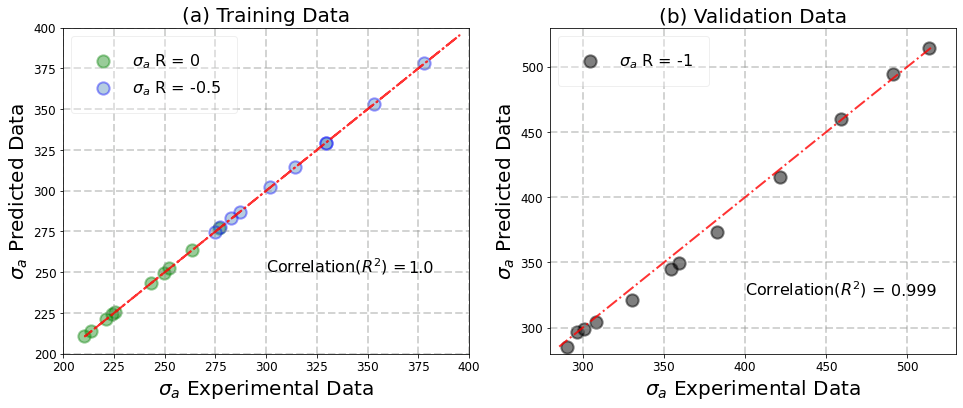

In [14]:

plt.figure(figsize=(16,6))

# Subplot1 training data
plt.subplot(1,2,1)
preds =  modelPnnFatigue.predict(X_train)
plt.plot(Y_train[5:-3]*568/2,Y_train[5:-3]*568/2,color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(preds[0+5:11+4]*568/2,Y_train[0+5:11+4]*568/2,color="green",edgecolors="green", s =150,alpha = 0.4,linewidth=2, label = ( r'$σ_{a}$' ' R = 0')) #observerd 
plt.scatter(preds[12+4:-2]*568/2,Y_train[12+4:-2]*568/2,color="steelblue",edgecolors="#0000FF", s =150,alpha = 0.4,linewidth=2,label = ( r'$σ_{a}$' ' R = -0.5')) #observerd 
plt.xlabel(( r'$σ_{a}$' ' Experimental Data'),size=20)
plt.ylabel(( r'$σ_{a}$' ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1)
plt.title("(a) Training Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.xlim([200,400])
plt.ylim([200,400])
plt.text(300, 250, ('Correlation' r'$(R^{2}$' ') = '), fontsize = 16)
plt.text(370, 250, round (train_corr[0],3) , fontsize = 16)

# subplot2 validation data
plt.subplot(1,2,2)
preds =  modelPnnFatigue.predict(X_valid)
plt.plot(Y_valid[2:]*568/2,Y_valid[2:]*568/2,color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(preds*568/2,Y_valid*568/2,color="black",edgecolors="black", s =150,alpha = 0.5,linewidth=2,label = ( r'$σ_{a}$' ' R = -1')) #observerd 
plt.xlabel(( r'$σ_{a}$' ' Experimental Data'),size=20)
plt.ylabel(( r'$σ_{a}$' ' Predicted Data'),size=20)
plt.title("(b) Validation Data", size = 20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.xlim([280,530])
plt.ylim([280,530])
plt.text(400, 325, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(490, 325, round (val_corr[0],3) , fontsize = 16)
plt.show()

# Probabilistic S-N curve base on PNN prediction 

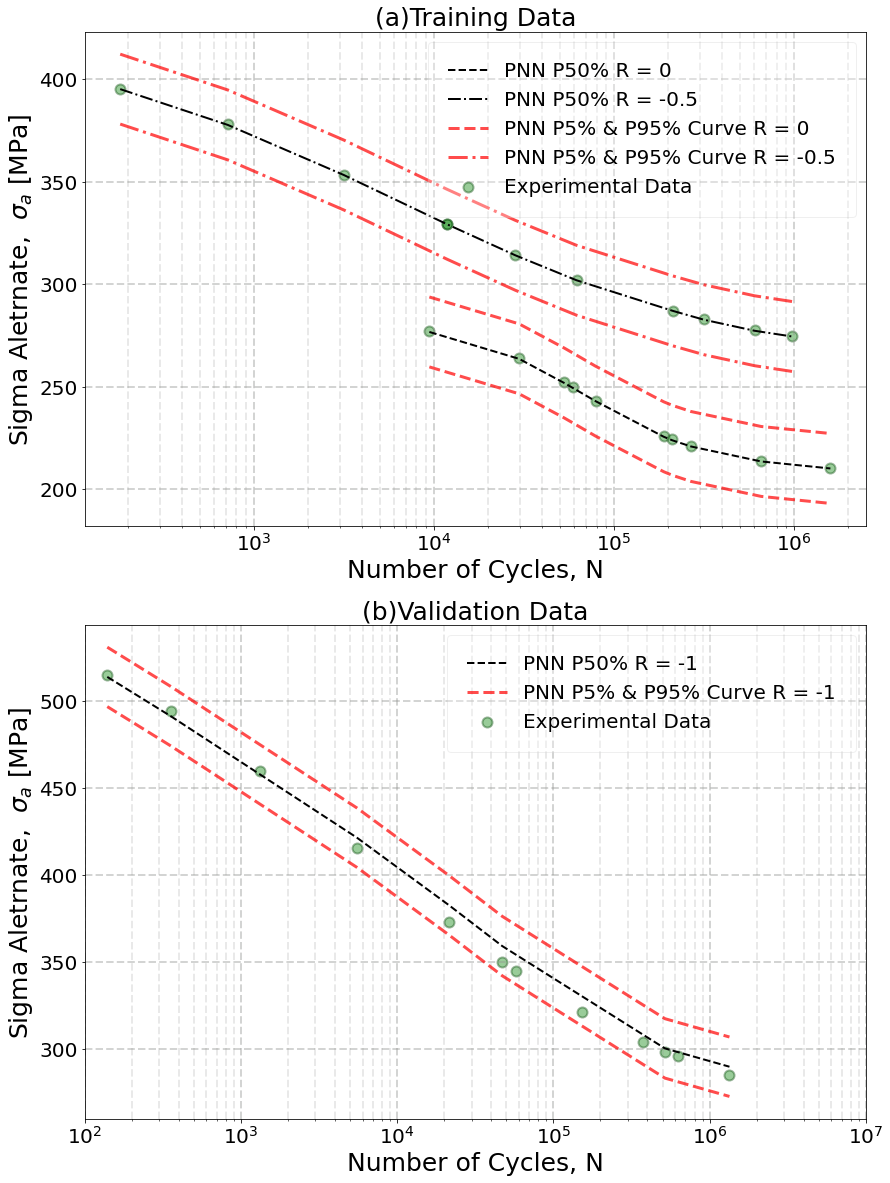

In [15]:
# get uncertainty model
modelPnnFatigue_sd = Model(inputs=inputs, outputs=dist.stddev())
# Create prediction graph
plt.figure(figsize=(14,20))

# Subplot1 training data
plt.subplot(2,1,1)

preds = modelPnnFatigue.predict(X_train)

plt.scatter(np.power(10,[X_train["nNormalized"][5:-2]*7]),Y_train[5:-2]*568/2,color="#008000",
            alpha = 0.4,s=100,linewidth=2, edgecolors="#054907",label = 'Experimental Data')

plt.plot((np.power(10,[X_train["nNormalized"][5:11+4]*7])).reshape([-1,1]),np.array(preds[5:11+4]*568/2).reshape([-1,1]),
         color="black", alpha = 1,linestyle="--",linewidth=2,label = 'PNN P50% R = 0')

plt.plot((np.power(10,[X_train["nNormalized"][11+4:-2]*7])).reshape([-1,1]),np.array(preds[11+4:-2]*568/2).reshape([-1,1]),
          color="black", alpha = 1,linewidth=2,linestyle="-.",label = 'PNN P50% R = -0.5')

plt.plot(np.power(10,np.array (X_train["nNormalized"][5:11+4]).reshape([-1,1]) * 7),
          (preds[5:11+4] +3*modelPnnFatigue_sd.predict(X_train)[5:11+4])*284,color="red",linestyle="--",alpha =0.7, linewidth=3)

plt.plot(np.power(10,np.array (X_train["nNormalized"][5:11+4]).reshape([-1,1]) * 7),
          (preds[5:11+4] -3*modelPnnFatigue_sd.predict(X_train)[5:11+4])*284,color="red",
          linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P5% & P95% Curve R = 0')

plt.plot(np.power(10,np.array (X_train["nNormalized"][11+4:-2]).reshape([-1,1]) * 7),
          (preds[11+4:-2] -3*modelPnnFatigue_sd.predict(X_train)[11+4:-2])*284,color="red",
          linestyle="-.",alpha  = 0.7,linewidth=3,label = 'PNN P5% & P95% Curve R = -0.5')

plt.plot(np.power(10,np.array (X_train["nNormalized"][11+4:-2]).reshape([-1,1]) * 7),
          (preds[11+4:-2] +3*modelPnnFatigue_sd.predict(X_train)[11+4:-2])*284,color="red",
          linestyle="-.",alpha  = 0.7,linewidth=3) 

plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.xscale('log')



# Subplot2 validation data

plt.subplot(2,1,2)
preds = modelPnnFatigue.predict(X_valid)

plt.scatter(np.power(10,[X_valid["nNormalized"]*7]),Y_valid*568/2,color="#008000",
            alpha = 0.4,s=100,linewidth=2, label = 'Experimental Data',edgecolors="#054907",)

plt.plot((np.power(10,[X_valid["nNormalized"][2:]*7])).reshape([-1,1]),np.array(preds[2:]*568/2).reshape([-1,1]),
         color="black", alpha = 1,linestyle="--",linewidth=2,label = 'PNN P50% R = -1')

plt.plot(np.power(10,np.array (X_valid["nNormalized"][2:]).reshape([-1,1]) * 7),
         (preds[2:] +3*modelPnnFatigue_sd.predict(X_valid)[2:])*284,color="red",linestyle="--",alpha =0.7, linewidth=3)

plt.plot(np.power(10,np.array (X_valid["nNormalized"][2:]).reshape([-1,1]) * 7),
         (preds[2:] -3*modelPnnFatigue_sd.predict(X_valid)[2:])*284,color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P5% & P95% Curve R = -1')


plt.xlabel("Number of Cycles, N",size=25)
plt.ylabel(('Sigma Aletrnate,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("(b)Validation Data", size = 25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.xlim([100,10000000])
plt.xscale('log')
plt.grid(True)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Artificial constant life diagram for fatigue data by PNN algorithm: failure probability of 50%.

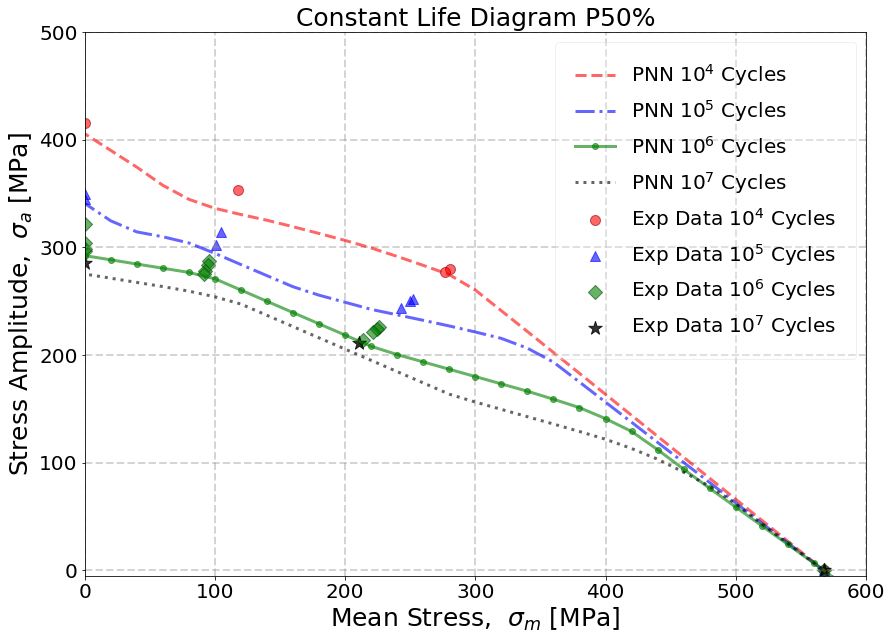

In [16]:
# generate sigma M data
sigmaM =np.arange(-1000,2000,20, dtype = float)
sigmaM_nor = sigmaM/568 # normalize sigmaM

# generate 10^4 cycles data
N104= np.ones(150)*10000.0
N104_nor = np.log10( N104 )/7
test_data104 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N104_nor})
preds104 = modelPnnFatigue.predict(test_data104)

# generate 10^5 cycles data
N105= np.ones(150)*100000.0
N105_nor = np.log10( N105 )/7
test_data105 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N105_nor})
preds105 = modelPnnFatigue.predict(test_data105)

# generate 10^6 cycles data
N106= np.ones(150)*1000000.0
N106_nor = np.log10( N106 )/7
test_data106 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N106_nor})
preds106 = modelPnnFatigue.predict(test_data106)

# generate 10^7 cycles data
N107= np.ones(150)*10000000.0
N107_nor = np.log10( N107 )/7
test_data107 = pd.DataFrame({'sigmaMeanNormalized':sigmaM_nor,'nNormalized':N107_nor})
preds107 = modelPnnFatigue.predict(test_data107)

# Process all data to create CLD graph with Exp data
Alldata_train = [X_train[:], X_valid[3:]]
Alldata_train = pd.concat(Alldata_train).reset_index(drop=True)
Alldata_valid = [Y_train[:], Y_valid[3:]]
Alldata_valid = pd.concat(Alldata_valid).reset_index(drop=True)
Alldata = [Alldata_train,Alldata_valid]
Alldata = pd.concat(Alldata , axis= 1)
Alldata['sigmaMean'] = Alldata['sigmaMeanNormalized']*568
Alldata['N'] = 10**(Alldata['nNormalized']*7)
Alldata['sigmaA'] = Alldata['Target']*284
AllExp104 = Alldata[(Alldata['N']>1000) & (Alldata['N']<10000)]
AllExp104.drop([26], inplace= True)
AllExp105 = Alldata[(Alldata['N']>10000) & (Alldata['N']<100000)]
AllExp105.drop([6,18,19,30], inplace= True)
AllExp106 = Alldata[(Alldata['N']>100000) & (Alldata['N']<1000000)]
AllExp107 = Alldata[(Alldata['N']>1000000)]

# Plot resulted CLD

#create figure
plt.figure(figsize=(14,10))

plt.plot(test_data104['sigmaMeanNormalized']*568,preds104*284,color="red",
            alpha = 0.6,linewidth=3, linestyle='--',label = ('PNN '  r'$10^{4}$' ' Cycles'))
plt.plot(test_data105['sigmaMeanNormalized']*568,preds105*284,color="blue",
            alpha = 0.6,linewidth=3,linestyle='-.',label = ('PNN '  r'$10^{5}$' ' Cycles'))
plt.plot(test_data106['sigmaMeanNormalized']*568,preds106*284,'go-',
            alpha = 0.6,linewidth=3, label = ('PNN '  r'$10^{6}$' ' Cycles'))
plt.plot(test_data107['sigmaMeanNormalized']*568,preds107*284,color="black",
            alpha = 0.6,linewidth=3,linestyle=':',label = ('PNN '  r'$10^{7}$' ' Cycles'))
plt.scatter(AllExp104['sigmaMean'], AllExp104['sigmaA'],color="red",
            alpha = 0.6,s=100,linewidth=1, label = ('Exp Data '  r'$10^{4}$' ' Cycles'),edgecolors="#8c000f")
plt.scatter(AllExp105['sigmaMean'], AllExp105['sigmaA'],color="blue",
            alpha = 0.6,s=100,linewidth=1,  marker='^',label = ('Exp Data '  r'$10^{5}$' ' Cycles'),edgecolors="#0000ff")
plt.scatter(AllExp106['sigmaMean'], AllExp106['sigmaA'],color="green",
            alpha = 0.6,s=100,linewidth=1,  marker='D',label = ('Exp Data '  r'$10^{6}$' ' Cycles'),edgecolors="#054907")
plt.scatter(AllExp107['sigmaMean'], AllExp107['sigmaA'] ,color="black",
            alpha = 0.8,s=200,linewidth=1,  marker='*',label = ('Exp Data '  r'$10^{7}$' ' Cycles'),edgecolors="black")

plt.xlabel(('Mean Stress,  ' r'$σ_{m}$' ' [MPa]'),size=25)
plt.ylabel(('Stress Amplitude,  ' r'$σ_{a}$' ' [MPa]'),size=25)
plt.title("Constant Life Diagram P50%", size = 25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.ylim ([-5,500])
plt.xlim ([0,600])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)


# PNN network with pipework data Non Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 0.001-0.002


# Import Data

In [25]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 001-002.csv')

# Prepare Data

In [32]:
Data_final = np.array(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.2, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

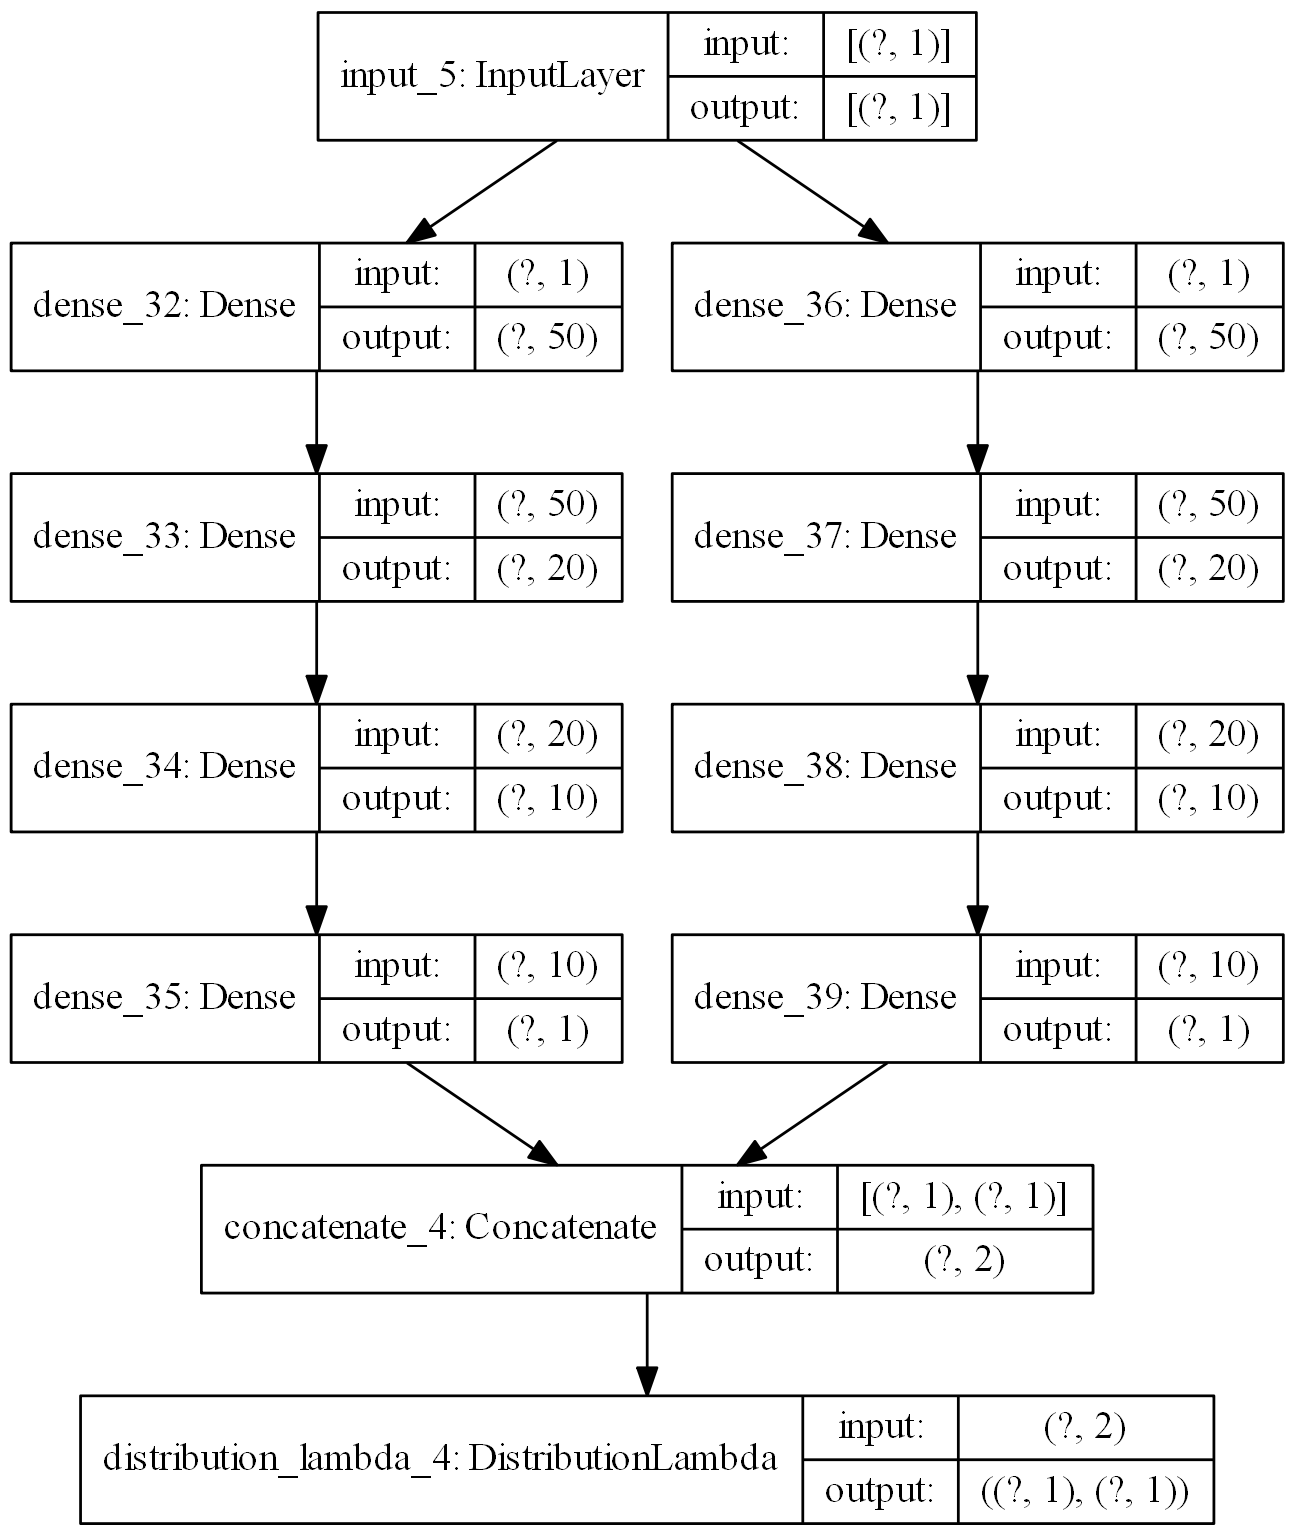

In [33]:

# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.25 + tf.math.softplus(0.05 * params[:,1:2]) )


# Create the PNN
inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR001 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR001.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR001, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)


# Training model

In [34]:
history1 = modelPnnPipeworkSR001.fit(train_data, train_traget, epochs=5000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

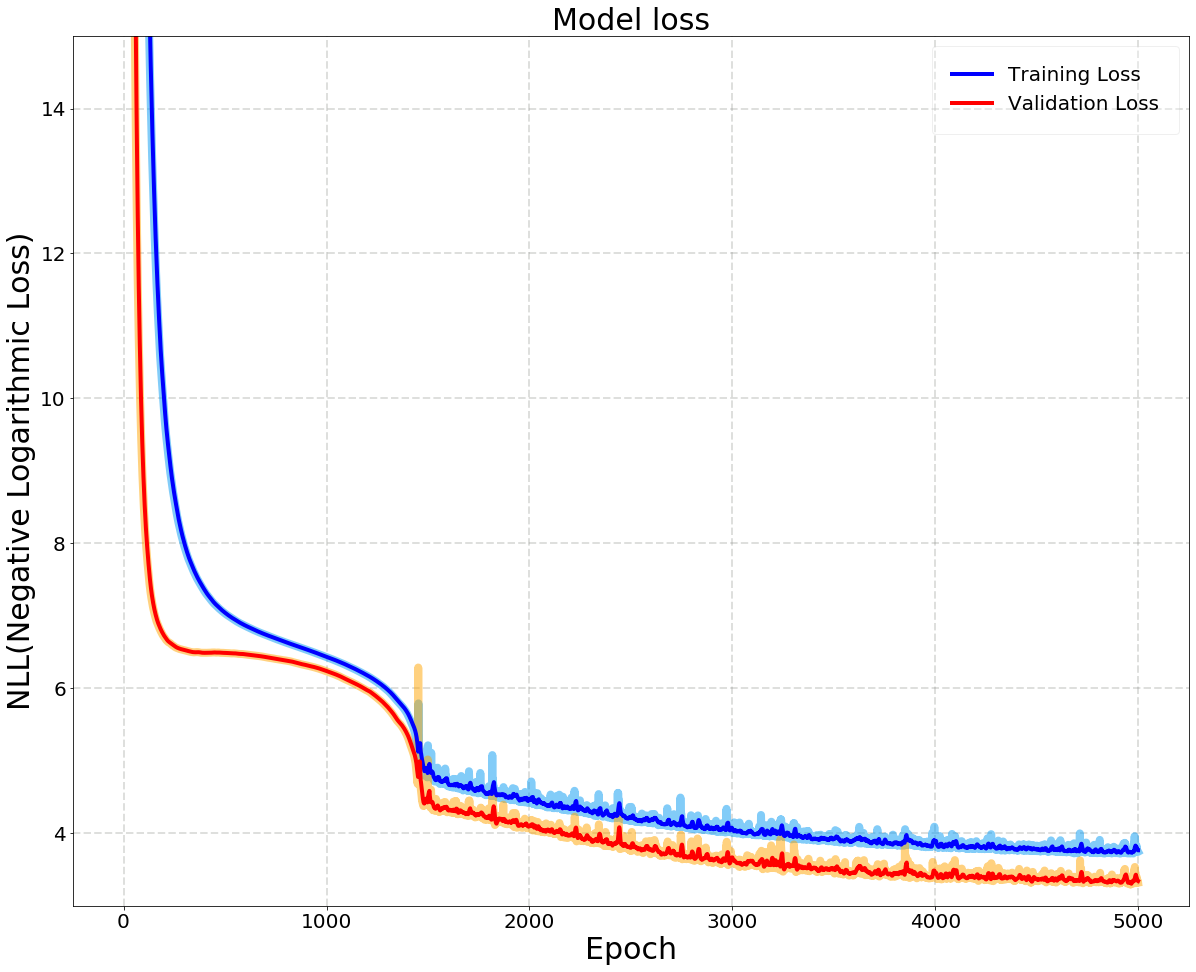

In [35]:
# Plot Model Loss
modelPnnPipeworkSR001 = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history1.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.gca().set_ylim(3,15)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

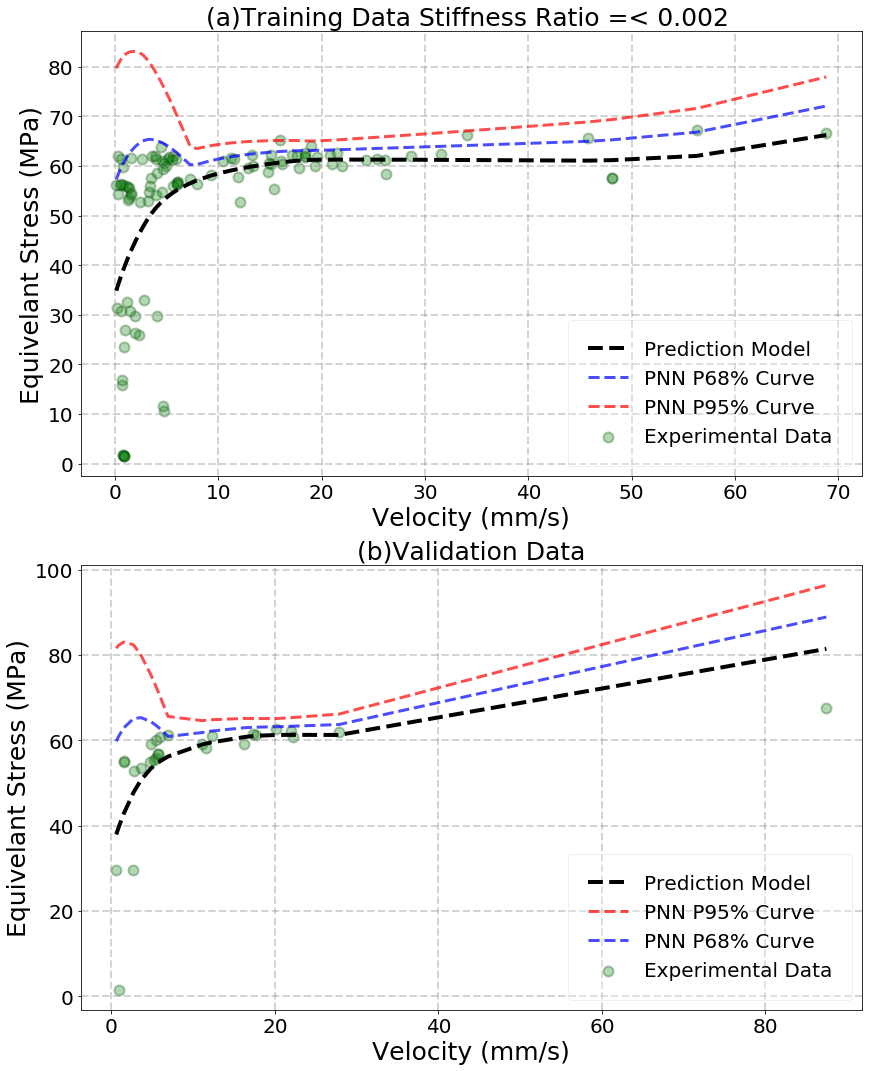

In [36]:
# Get model uncertainty
modelPnnPipeworkSR001_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)

preds = modelPnnPipeworkSR001.predict(train_data)
plt.scatter((train_set[:,0] ),
            (train_traget) ,
            color="#008000", alpha = 0.3,s=100,linewidth=2,edgecolors="#054907",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind] ),
         (preds[ind] ),
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model')

preds_sd = (preds+ 1* modelPnnPipeworkSR001_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),color="blue",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 2* modelPnnPipeworkSR001_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(a)Training Data Stiffness Ratio =< 0.002 ",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR001.predict(test_data)
plt.scatter((test_data) ,
            (test_traget) ,color="#008000", alpha = 0.3,s=100,linewidth=2,
            label = 'Experimental Data',edgecolors="#054907")
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind]) ,
         (preds[ind]) ,
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model') 

preds_sd = preds+2* modelPnnPipeworkSR001_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="red",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

preds_sd = preds+ 1* modelPnnPipeworkSR001_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="blue",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Calculate correaltion factor for training and validation data

In [51]:
# Training data correaltion
# preds = modelPnnPipeworkSR001.predict(train_data)
# train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
# print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds = modelPnnPipeworkSR001.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ',val_corr)


Training Person correlation is   (0.7208672520012596, 6.184437631105854e-05)


# PNN network with pipework data Non Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 0.002-0.1


# Import Data

In [27]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 01-02.csv')

# Prepare Data

In [28]:
Data_final = np.array(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.2, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

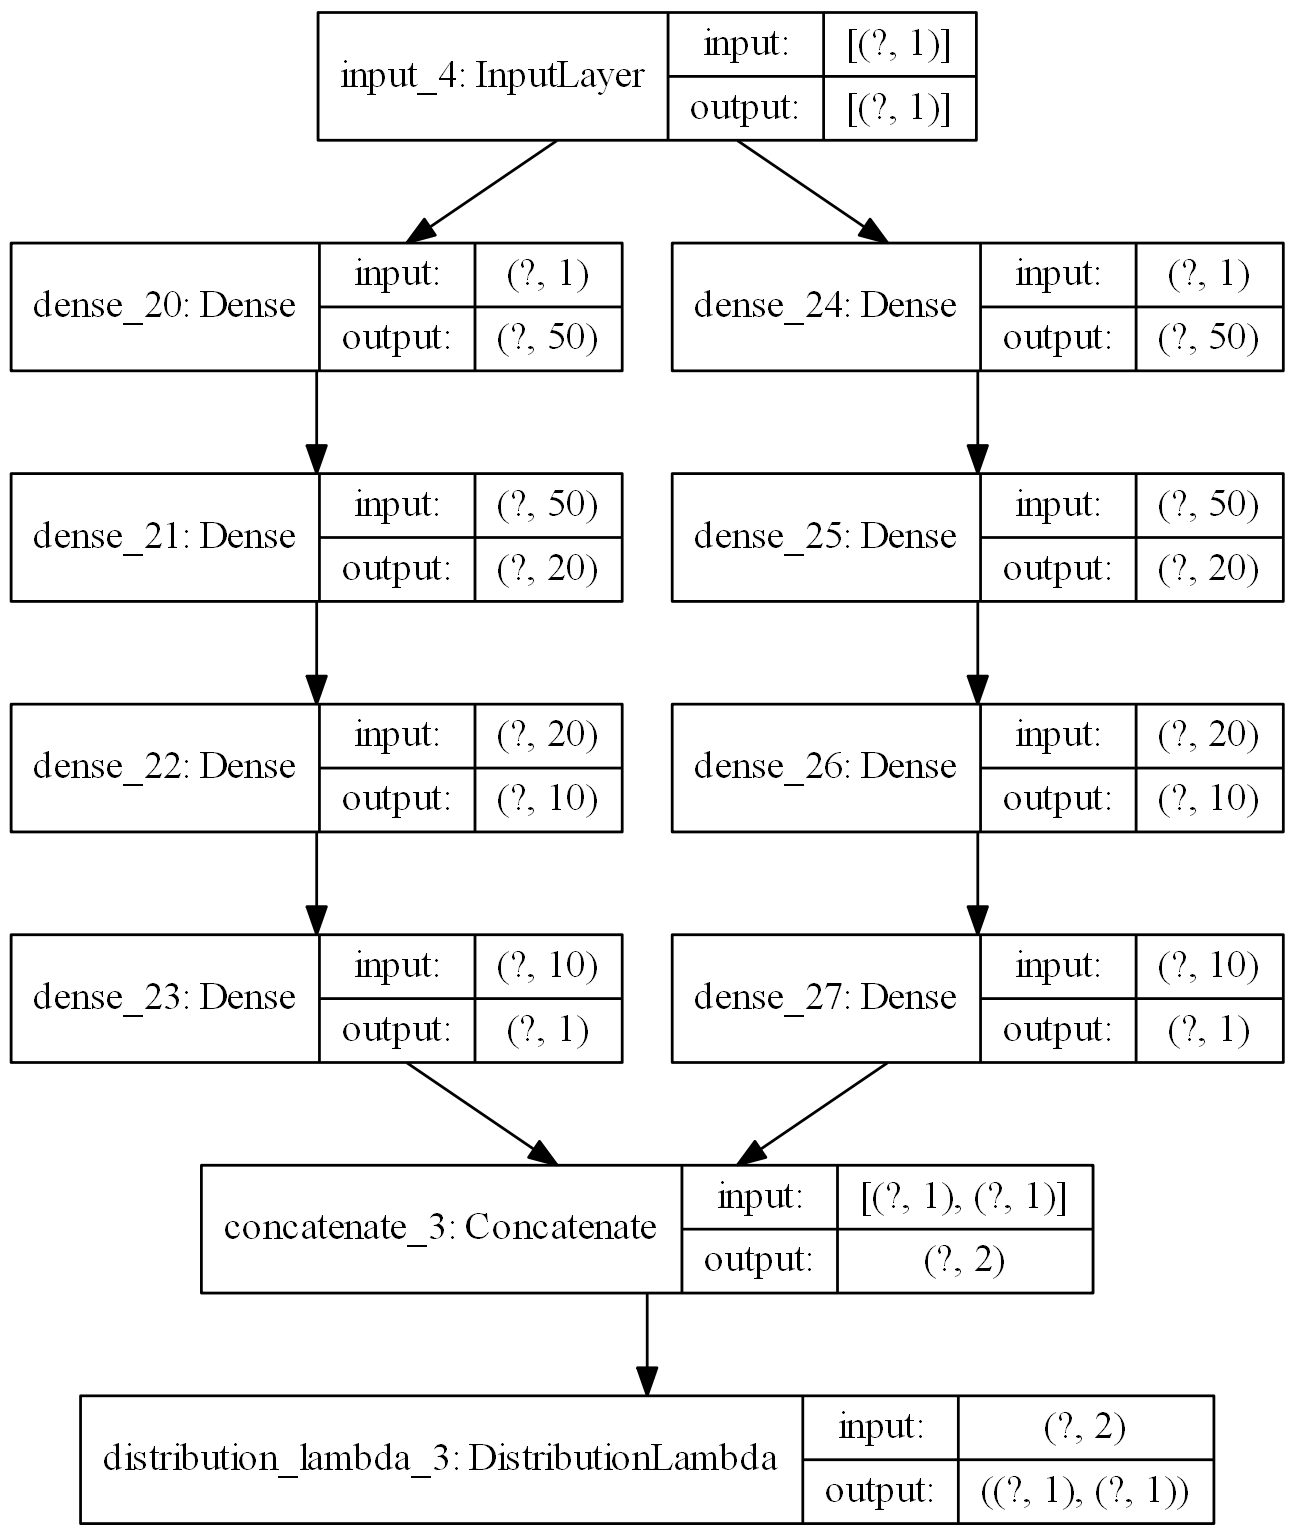

In [29]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.25 + tf.math.softplus(0.05 * params[:,1:2]) )


# Create the PNN
inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR01 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR01.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR01, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [30]:
history2 = modelPnnPipeworkSR01.fit(train_data, train_traget, epochs=2000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

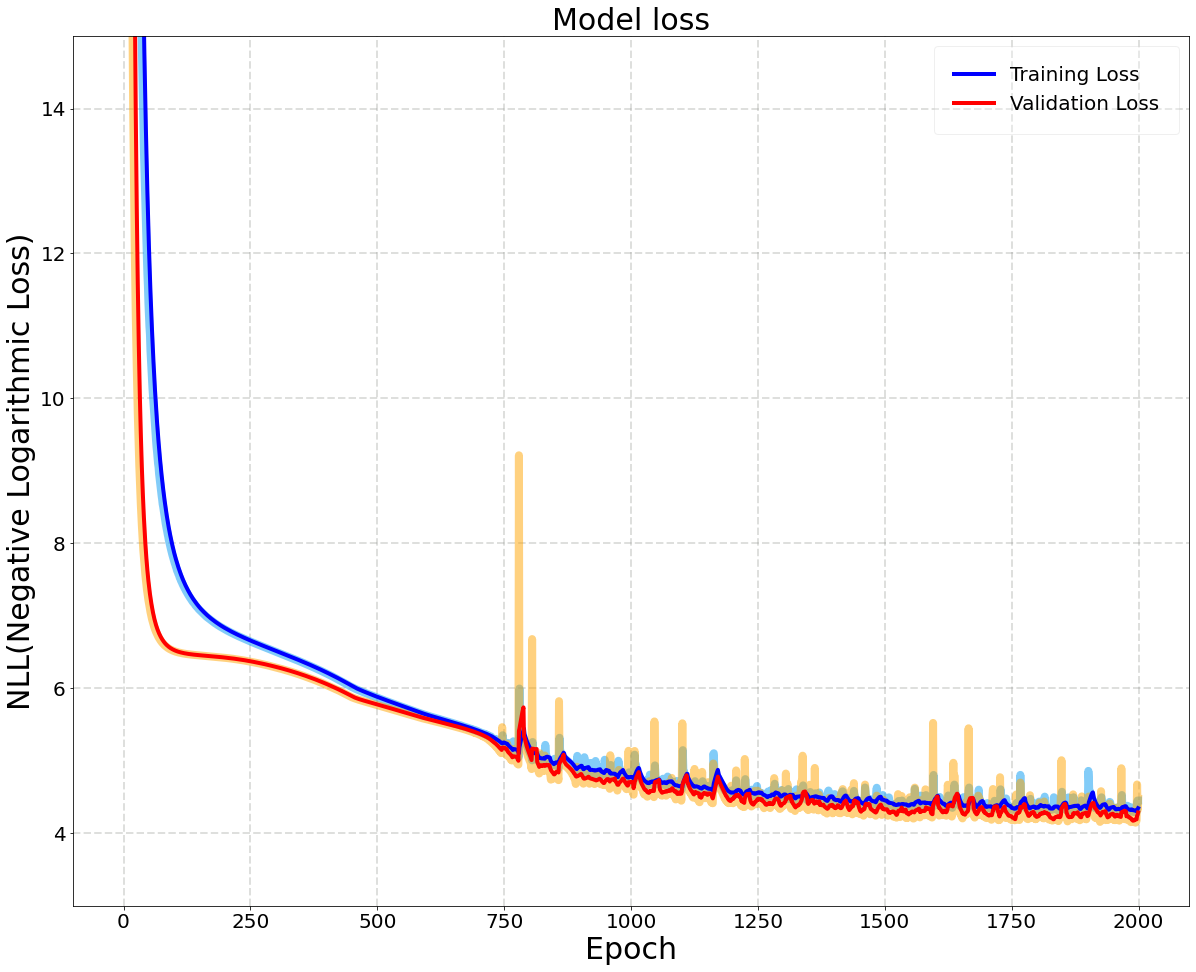

In [32]:
# Plot Model Loss
modelPnnPipeworkSR01 = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history2.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.gca().set_ylim(3,15)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

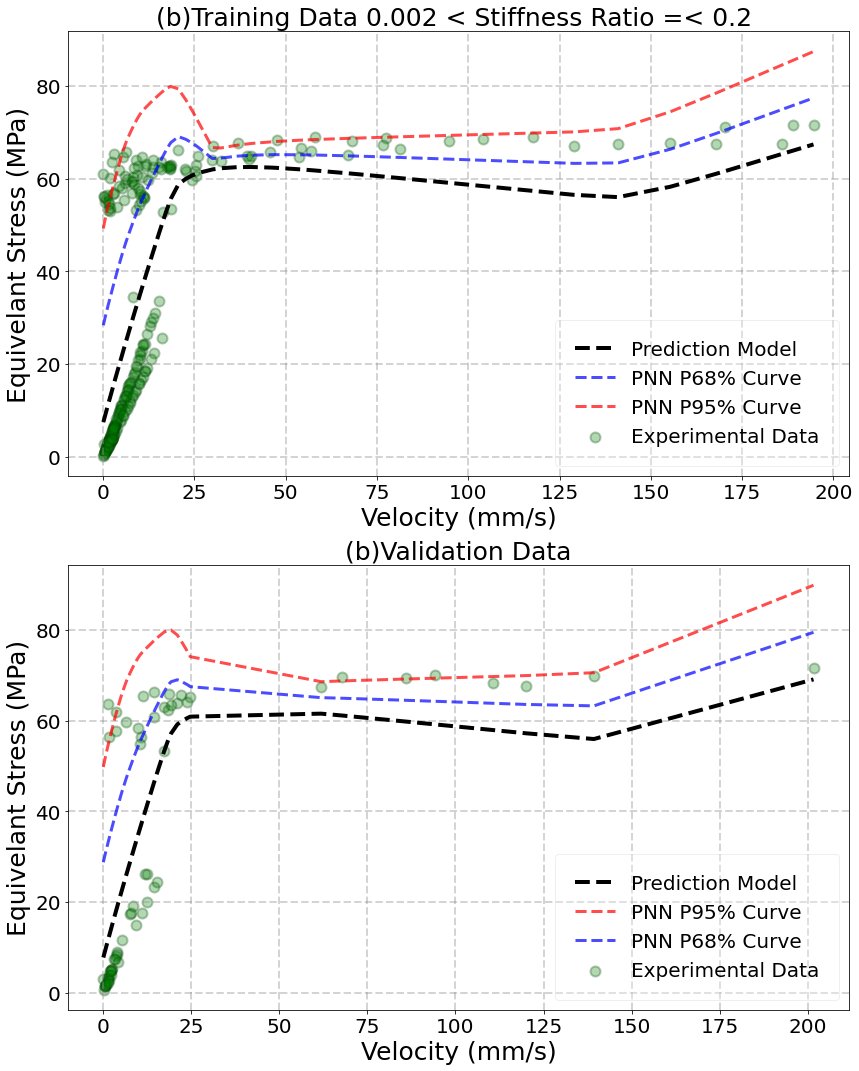

In [33]:
# Get model uncertainty
modelPnnPipeworkSR01_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)

preds = modelPnnPipeworkSR01.predict(train_data)
plt.scatter((train_set[:,0] ),
            (train_traget) ,
            color="#008000", alpha = 0.3,s=100,linewidth=2,edgecolors="#054907",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind] ),
         (preds[ind] ),
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model')

preds_sd = (preds+ 1* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),color="blue",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')

preds_sd = (preds+ 2* modelPnnPipeworkSR01_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Training Data 0.002 < Stiffness Ratio =< 0.2 ",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR01.predict(test_data)
plt.scatter((test_data) ,
            (test_traget) ,color="#008000", alpha = 0.3,s=100,linewidth=2,
            label = 'Experimental Data',edgecolors="#054907")
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind]) ,
         (preds[ind]) ,
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model') 

preds_sd = preds+2* modelPnnPipeworkSR01_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="red",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

preds_sd = preds+ 1* modelPnnPipeworkSR01_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="blue",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

In [34]:
# Training data correaltion
# preds =  modelPnnPipeworkSR01.predict(train_data)
# train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
# print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds =  modelPnnPipeworkSR01.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

Training Person correlation is   (0.8053913086486981, 1.0283092348647162e-15)


# PNN network with pipework data Non Constant variant (Velocity vs Stress)
## Data for Stiffness ratio between 5-20


# Import Data

In [65]:
# get data from csv file
Data = pd.read_csv('Pipework data SR 5-20.csv')

# Prepare Data

In [72]:
Data_final = np.array(Data)

# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.25, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

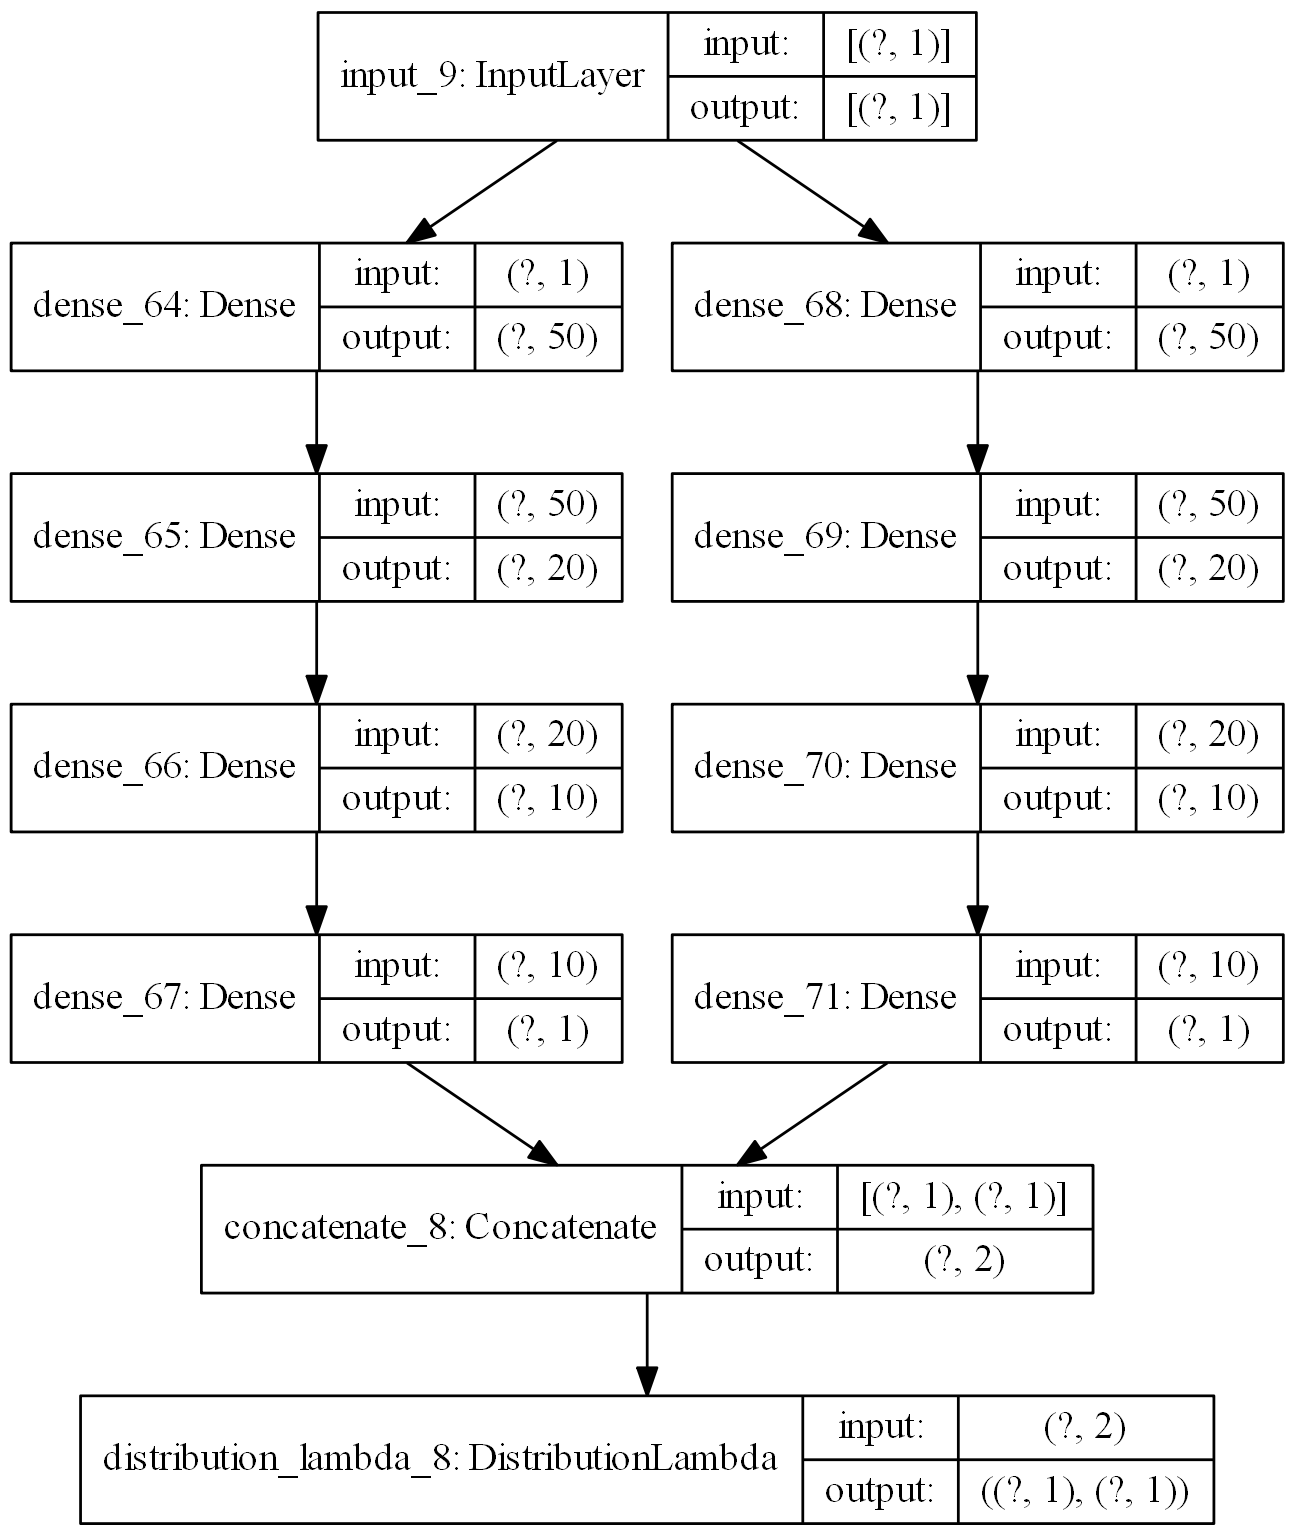

In [73]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=0.25+ tf.math.softplus(0.05 * params[:,1:2]))


# Create the PNN
inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the model and compile it
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSR5 = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSR5.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSR5, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [74]:
history3 = modelPnnPipeworkSR5.fit(train_data, train_traget, epochs=8000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

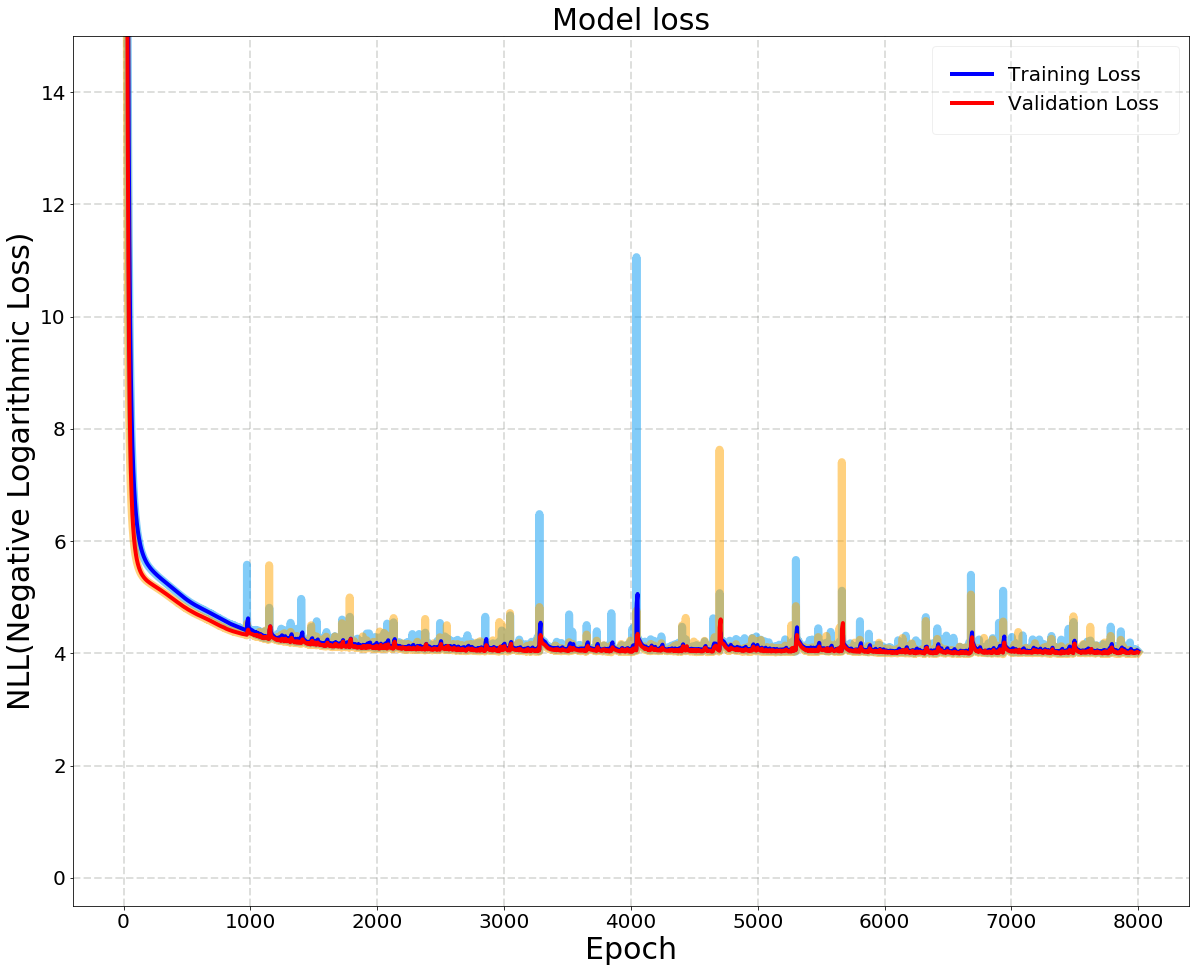

In [75]:
# Plot Model Loss
modelPnnPipeworkSR5 = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history3.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.gca().set_ylim(-0.5,15)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

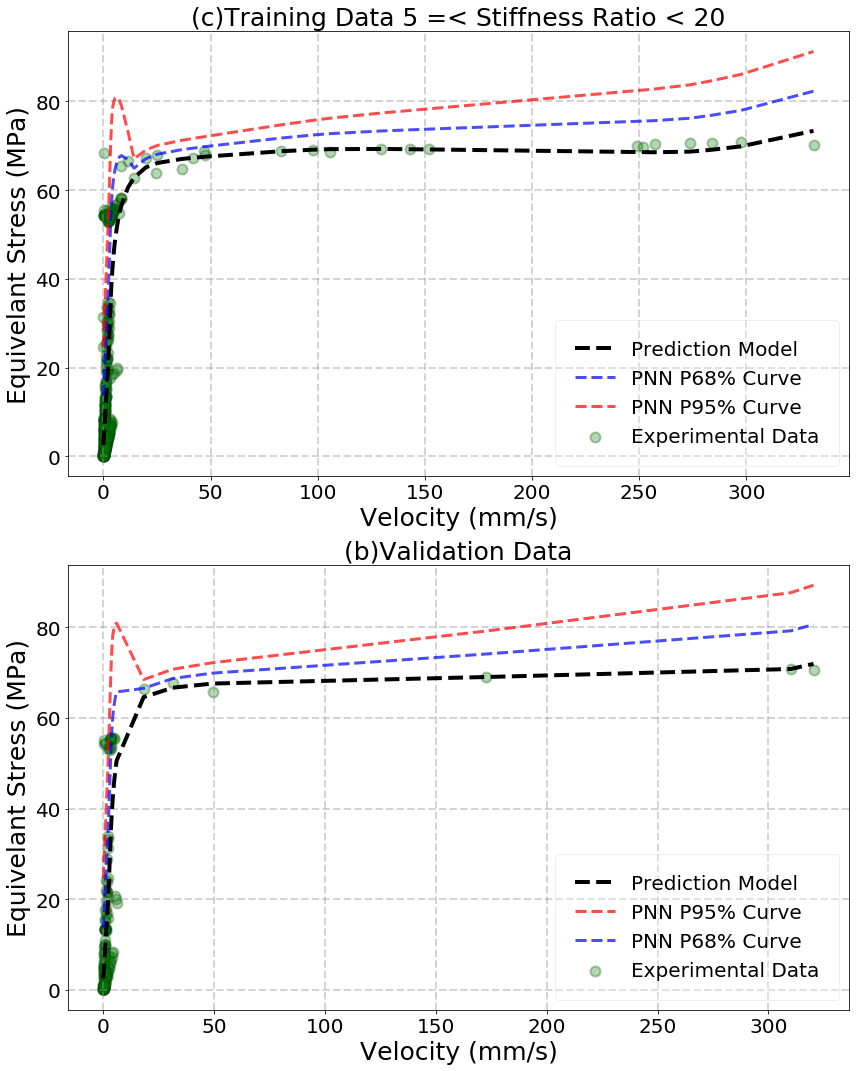

In [76]:
# Get model uncertainty
modelPnnPipeworkSR5_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)
preds = modelPnnPipeworkSR5.predict(train_data)
plt.scatter((train_set[:,0] ),
            (train_traget) ,
            color="#008000", alpha = 0.3,s=100,linewidth=2,edgecolors="#054907",label = 'Experimental Data')
ind = np.argsort (train_data,axis = 0)
plt.plot((train_set[:,0][ind] ),
         (preds[ind] ),
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model')
preds_sd = (preds+ 1* modelPnnPipeworkSR5_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),color="blue",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 2* modelPnnPipeworkSR5_sd.predict(train_data))
plt.plot((train_set[:,0][ind] ),
         (preds_sd[ind] ),color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(c)Training Data 5 =< Stiffness Ratio < 20" ,size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)



# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSR5.predict(test_data)
plt.scatter((test_data) ,
            (test_traget) ,color="#008000", alpha = 0.3,s=100,linewidth=2,
            label = 'Experimental Data',edgecolors="#054907")
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind]) ,
         (preds[ind]) ,
         color="black", linestyle='--',linewidth=4, label = 'Prediction Model') 
preds_sd = preds+2* modelPnnPipeworkSR5_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="red",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSR5_sd.predict(test_data)
plt.plot((test_data[ind]) ,
         (preds_sd[ind]) ,
         color="blue",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)

plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Calculate correaltion factor for training and validation data

In [80]:
# Training data correaltion
# preds = modelPnnPipeworkSR5.predict(train_data)
# train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
# print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds = modelPnnPipeworkSR5.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

Training Person correlation is   (0.7588778899527895, 3.942136706693412e-25)


# PNN network with pipework data Non Constant variant (Velocity vs Stress)
## All Data 


# Import Data

In [43]:
# get data from csv file
Data = pd.read_csv('Pipework data SR All.csv')

# Prepare Data

In [46]:
Data_final = np.array(Data)
# Spliting data into training and testing
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Data_final, test_size=0.25, random_state=42)
train_data = train_set[:,0]
train_traget = train_set[:,2]
test_data = test_set[:,0]
test_traget =  test_set[:,2]


# Create PNN

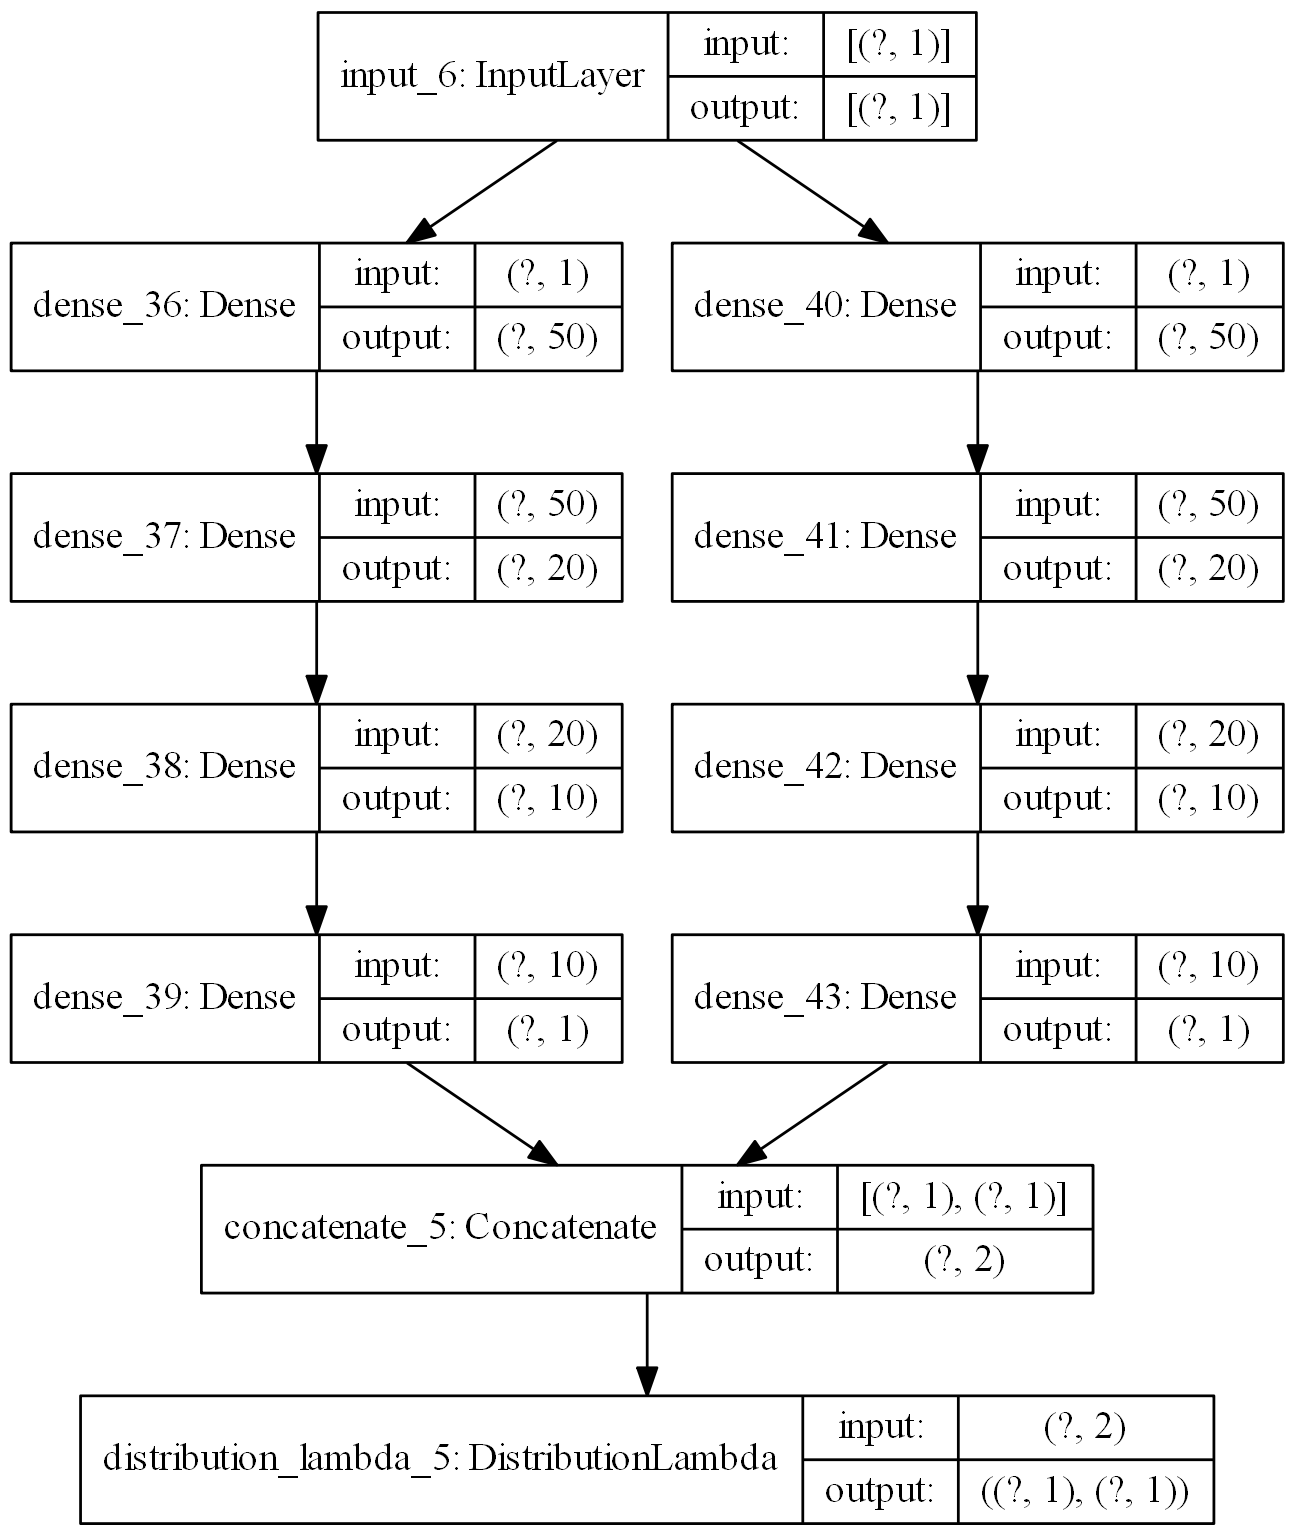

In [45]:
# Probablistic network the varaince consider in the case is constant 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define loss function (Negative Log Likelihood)
def NLL(y, distr): 
  return -distr.log_prob(y) 

# Define the used distribution for fitting 
def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1+ tf.math.softplus(0.05 * params[:,1:2]))

inputs = Input(shape=(1,))
hidden0= Dense(50,kernel_initializer="he_normal",
               activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden01= Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden0)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden02= Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden01)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out1 = Dense(1)(hidden02) 
hidden1 = Dense(50,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(inputs)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden2 = Dense(20,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2 =0.001))(hidden1)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
hidden3 = Dense(10,kernel_initializer="he_normal",
                activation='elu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,l2 =0.001))(hidden2)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.2)
out2 = Dense(1)(hidden3) 
params = Concatenate()([out1,out2]) 

# Create the PNN
dist = tfp.layers.DistributionLambda(my_dist)(params) 
modelPnnPipeworkSRAll = Model(inputs=inputs, outputs=dist) 
modelPnnPipeworkSRAll.compile(Adam(learning_rate=0.001), loss=NLL) 
keras.utils.plot_model(modelPnnPipeworkSRAll, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=200)




# Training model

In [47]:
history3 = modelPnnPipeworkSRAll.fit(train_data, train_traget, epochs=8000, verbose=0, validation_data=(test_data,test_traget), shuffle= True)

# Loss evaluation

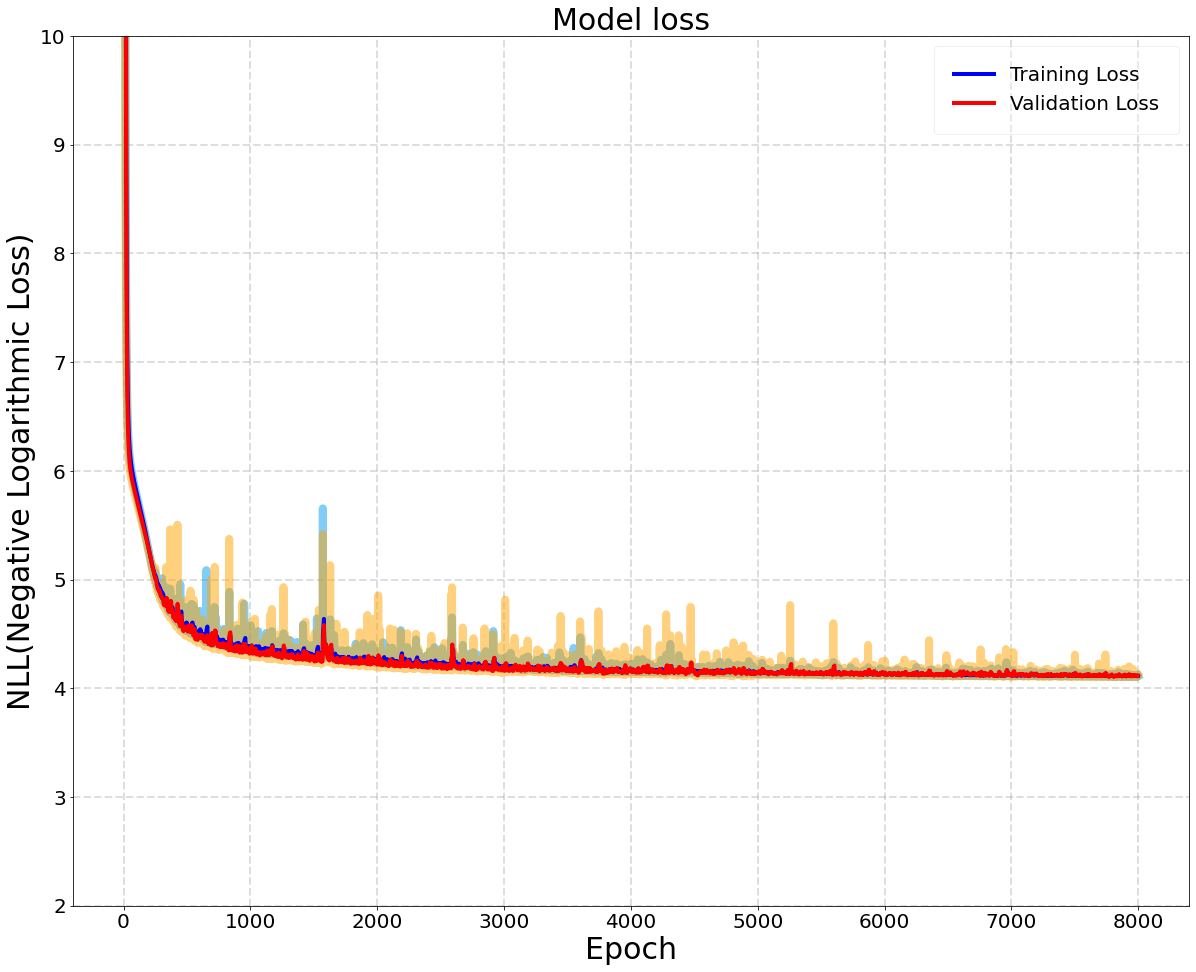

In [48]:
# Plot Model Loss
modelPnnPipeworkSRAll = Model(inputs=inputs, outputs=dist.mean())
df = pd.DataFrame(history3.history)
df['Val_loss_mean'] = df.iloc[:,1].rolling(window=10).mean()
df['loss_mean'] = df.iloc[:,0].rolling(window=10).mean()
plt.figure(figsize=(20,16))
plt.plot(df['loss'], alpha = 0.5,linewidth=8,color = '#069AF3' )
plt.plot(df['val_loss'], alpha =0.5,linewidth=8, color = 'orange')
plt.plot(df['loss_mean'],linewidth=4,color = 'blue', label = 'Training Loss')
plt.plot(df['Val_loss_mean'],linewidth=4,color = 'red',label = 'Validation Loss')
plt.xlabel("Epoch",size=30)
plt.ylabel("NLL(Negative Logarithmic Loss)",size=30)
plt.title("Model loss",size=30)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.3)
plt.grid(True)
plt.gca().set_ylim(2,10)
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()

# Plot real data against predicted data

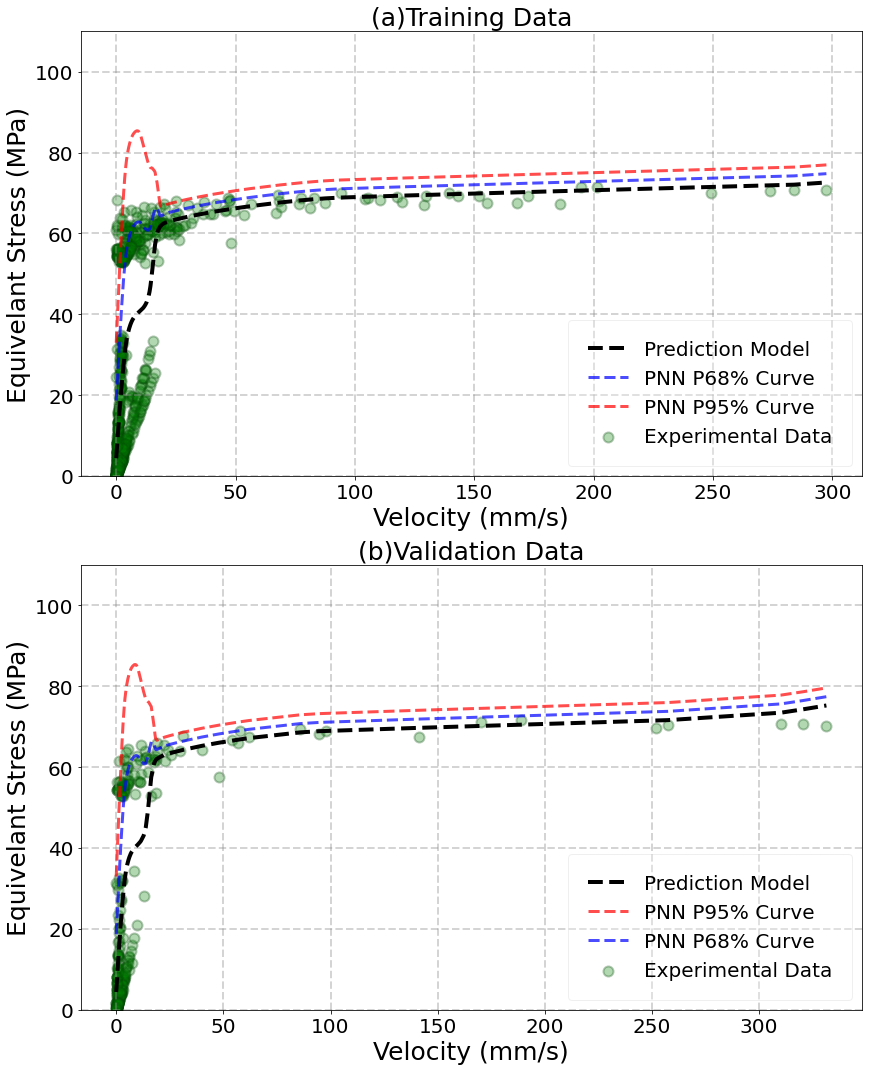

In [49]:
# Get model uncertainty
modelPnnPipeworkSRAll_sd = Model(inputs=inputs, outputs=dist.stddev())

# Create figure
plt.figure(figsize=(14,18))

# Subplot1 training data
plt.subplot(2,1,1)

preds = modelPnnPipeworkSRAll.predict(train_data)
plt.scatter((train_set[:,0]),(train_traget),color="#008000", alpha = 0.3,
            s=100,linewidth=2,edgecolors="#054907",label = 'Experimental Data')

ind = np.argsort (train_data,axis = 0)
plt.plot(train_set[:,0][ind],preds[ind],color="black", linestyle='--',linewidth=4, label = 'Prediction Model')

preds_sd = (preds+ 1* modelPnnPipeworkSRAll_sd.predict(train_data))
plt.plot(train_set[:,0][ind],preds_sd[ind],color="blue",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')
preds_sd = (preds+ 2* modelPnnPipeworkSRAll_sd.predict(train_data))
plt.plot((train_set[:,0][ind]),(preds_sd[ind]),color="red",
         linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')

plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(a)Training Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.ylim([0,110])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)


# Subplot2 validation data
plt.subplot(2,1,2)
preds = modelPnnPipeworkSRAll.predict(test_data)
plt.scatter((test_data),(test_traget),color="#008000", alpha = 0.3,s=100,linewidth=2,label = 'Experimental Data',edgecolors="#054907")
ind = np.argsort (test_data,axis = 0)
plt.plot((test_data[ind]),(preds[ind]),color="black", linestyle='--',linewidth=4, label = 'Prediction Model') 

preds_sd = preds+2* modelPnnPipeworkSRAll_sd.predict(test_data)
plt.plot((test_data[ind]),(preds_sd[ind]),color="red",linestyle="--",
         alpha  = 0.7,linewidth=3,label = 'PNN P95% Curve')
preds_sd = preds+ 1* modelPnnPipeworkSRAll_sd.predict(test_data)
plt.plot((test_data[ind]),(preds_sd[ind]),
         color="blue",linestyle="--",alpha  = 0.7,linewidth=3,label = 'PNN P68% Curve')
plt.ylabel("Equivelant Stress (MPa)",size=25)
plt.xlabel("Velocity (mm/s)",size=25)
plt.title("(b)Validation Data",size=25)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.2, which='minor')
plt.xticks(fontsize= 20 )
plt.yticks(fontsize= 20)
plt.ylim([0,110])
plt.legend(fontsize=20, framealpha=0.3,  borderpad=1)
plt.show()


# Calculate correaltion factor for training and validation data

In [50]:
# Training data correaltion
preds = modelPnnPipeworkSRAll.predict(train_data)
train_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(train_traget, dtype= np.float32))
print ('Training Person correlation is  ', train_corr)
# Validation data correaltion
preds = modelPnnPipeworkSRAll.predict(test_data)
val_corr = scipy.stats.pearsonr(np.array(preds).reshape([-1]), np.array(test_traget, dtype= np.float32))
print ('Training Person correlation is  ', val_corr)

Training Person correlation is   (0.7449044754597574, 8.971453661551152e-137)
Training Person correlation is   (0.7626204499333994, 5.741730117530616e-50)


# Plot real data vs predicted data

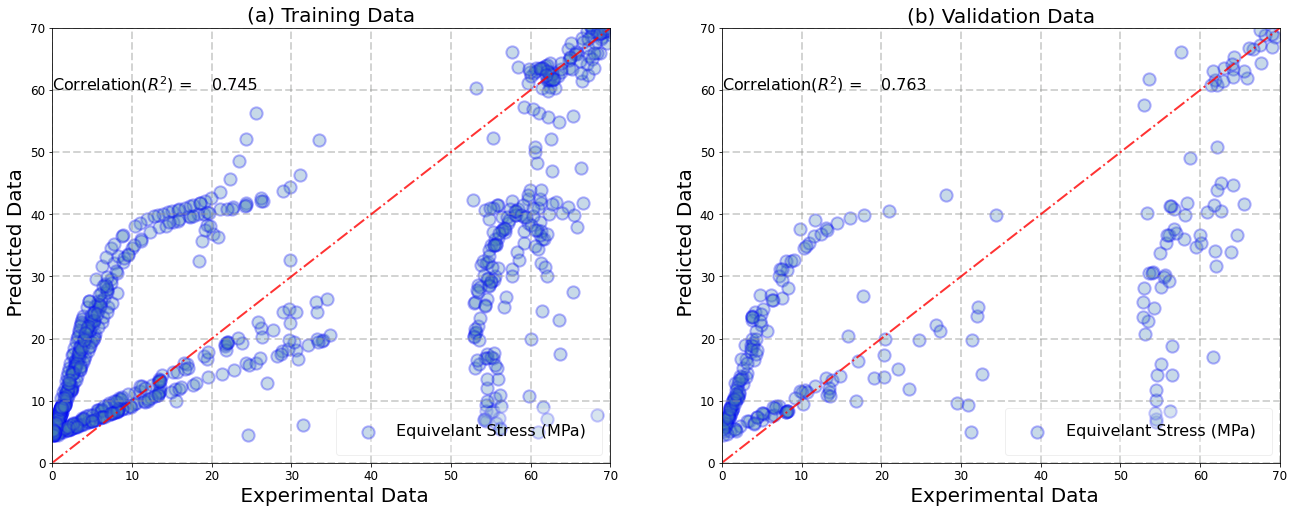

In [51]:
# Create figure
plt.figure(figsize=(22,8))

# Subplot1 training data
plt.subplot(1,2,1)
preds = modelPnnPipeworkSRAll.predict(train_data)
plt.plot((train_traget[np.argsort (train_traget,axis = 0)]),
         (train_traget[np.argsort (train_traget,axis = 0)]),
         color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(train_traget,preds,
            color="steelblue",edgecolors="#0000FF",
            s =150,alpha = 0.3,linewidth=2, label = "Equivelant Stress (MPa)") 
plt.xlabel(( ' Experimental Data'),size=20)
plt.ylabel(( ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1,loc=4)

plt.title("(a) Training Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.text(0, 60, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(20, 60, round (train_corr[0],3) , fontsize = 16)
plt.xlim([0,70])
plt.ylim([0,70])

# subplot2 validation data
plt.subplot(1,2,2)
preds = modelPnnPipeworkSRAll.predict(test_data)
plt.plot((test_traget[np.argsort (test_traget,axis = 0)]),
         (test_traget[np.argsort (test_traget,axis = 0)]),
         color="red",linewidth=2,alpha = 0.8, linestyle='-.')
plt.scatter(test_traget,
            preds ,color="steelblue",edgecolors="#0000FF",
            s =150,alpha = 0.3,linewidth=2, label = "Equivelant Stress (MPa)") 

plt.xlabel(( ' Experimental Data'),size=20)
plt.ylabel(( ' Predicted Data'),size=20)
plt.legend(fontsize=16, framealpha=0.3,  borderpad=1,loc=4)
plt.title("(b) Validation Data", size= 20)
plt.grid(color='#929591', linestyle='--', linewidth=2, alpha = 0.4)
plt.text(0, 60, 'Correlation' r'$(R^{2}$' ') = ' , fontsize = 16)
plt.text(20, 60, round (val_corr[0],3) , fontsize = 16)
plt.xlim([0,70])
plt.ylim([0,70])
plt.show()